# FGOALS Forecast

- Loads in all daily forecasts of sea ice for a given initial date (combines lead times and ensemble members, this is the slow part)
- Regrids to polar stereographic,
- Saves to netcdf files for each initial date

In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

# Standard Imports
#%matplotlib inline
#%load_ext autoreload
#%autoreload
import matplotlib
import scipy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import xesmf as xe
import os
from os import walk
import glob
import seaborn as sns
import pandas as pd
import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# ESIO Imports
from esio import import_data

#import dask
#from dask.distributed import Client

In [2]:
#client = Client(n_workers=8)
#client

In [3]:
# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [4]:
# Directories
model='fgoalssipn'
runType='forecast'
base_dir = r'/home/disk/sipn/nicway/data/'
ftp_dir = r'/home/disk/sipn/upload/'
data_dir = os.path.join(base_dir, 'model', model, runType)
data_out = os.path.join(base_dir, 'model', model, runType, 'sipn_nc')
stero_grid_file = os.path.join(base_dir, 'grids', 'stereo_gridinfo.nc')

In [7]:
# the number of ensemble members and lead times need to be the same each for each initial time
# or else our analysis will fail later
# at first this modeling group changed their file format a lot, but now they are almost always the same
# possibly the occasional variation is an upload error. Here we skip those "bad" initial times
ntimes_expecting = 65
nens_expecting = 16

# look for new data each day and concat into a manageable file

native_dir=os.path.join(data_dir,'native')
#orig_dir=os.path.join(native_dir,'orig')
orig_dir=os.path.join(ftp_dir,model,runType,'FGOALS-f2_S2S_v1.3')

print(orig_dir)

init_dates = []
for (dirpath, dirnames, filenames) in walk(orig_dir):
    init_dates.extend(dirnames)
    break
    
# remove directories that do not begin with "2"
for i in init_dates:
    if i[0] != '2':
        init_dates.remove(i)
        
print(init_dates)

for itstr in init_dates:
    itdata_dir=os.path.join(orig_dir,itstr)
    f_out = os.path.join(native_dir,model+'-'+itstr+'.nc')
    if (os.path.isfile(f_out)):
        print(f_out, ' already exists - skipping')
        continue

    ens_dirs = []
    for (dirpath, dirnames, filenames) in walk(itdata_dir):
        ens_dirs.extend(dirnames)
        break

    nens=len(ens_dirs)
    print('There are ',nens, ' ensemble members for this init time')
    
    if nens != nens_expecting:
        print('    wrong number of ensembe members, skipping this init time')
        continue
        
    print('The subdirectories with each ensemble member are: ',ens_dirs)
    
    correct_ntimes = True  # assume right number
    
    ds_list = []
    for esub in ens_dirs:
        tmp = esub.split('-')
        tmp = tmp[2]
        e=int(tmp[-2:])  
        cfiles = os.path.join(itdata_dir, esub)  
        print('Ensemble #',e,' for files:', cfiles)
        cfiles = os.path.join(cfiles, '*.cice.h1.*.nc') 
        files = glob.glob(cfiles) # Check we have files 
        if not files:
            print("No files found in subdir, skipping ensemble #", esub)
            continue
            
        ds = xr.open_mfdataset(cfiles, concat_dim='time') #,  parallel=True)

    #    # Add ensemble coord
        ds.coords['ensemble'] = e
        da=ds.aice_d
        da=da.expand_dims('ensemble')
        ds_list.append(da)

        ntimes = len(da.time.values)
        if ntimes != ntimes_expecting:
            correct_ntimes = False  
            print('    there are not 65 lead times, skipping ensemble #', esub)
            continue

    if correct_ntimes:
        print('merge to one and save file ',f_out)
        ds_all = xr.merge(ds_list)
        print(ds_all)
        ds_all.to_netcdf(f_out)

/home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3
['20191121', '20191125', '20190726', '20190725', '20190724', '20190729', '20190728', '20190727', '20190730', '20190731', '20190801', '20190802', '20190803', '20190804', '20190805', '20190806', '20190807', '20190808', '20190809', '20190810', '20190811', '20190812', '20190813', '20190814', '20190815', '20190816', '20190817', '20190818', '20190819', '20190820', '20190821', '20190823', '20190824', '20190825', '20190826', '20190827', '20190828', '20190829', '20190830', '20190831', '20190901', '20190902', '20191122', '20190822', '20190903', '20190904', '20190905', '20190906', '20190907', '20190908', '20190909', '20190910', '20190911', '20190912', '20190913', '20190914', '20190915', '20190916', '20190917', '20190918', '20190919', '20190920', '20190921', '20190922', '20190923', '20190924', '20190925', '20190926', '20190927', '20190928', '20190929', '20190930', '20191001', '20191002', '20191003', '20191004', '20191005', '20191006', '

Ensemble # 12  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-12
Ensemble # 13  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-13
No files found in subdir, Skipping ensemble # F1.3-20191210-13
Ensemble # 14  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-14
No files found in subdir, Skipping ensemble # F1.3-20191210-14
Ensemble # 21  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-21
No files found in subdir, Skipping ensemble # F1.3-20191210-21
Ensemble # 22  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-22
No files found in subdir, Skipping ensemble # F1.3-20191210-22
Ensemble # 23  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191210/F1.3-20191210-23
No files found in subdir, Skipping ensemble # F1.3-20191210-23
E

Ensemble # 44  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191212/F1.3-20191212-44
merge to one and save file  /home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20191212.nc
<xarray.Dataset>
Dimensions:   (ensemble: 16, time: 65, x: 320, y: 112)
Coordinates:
  * ensemble  (ensemble) int64 11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 44
    TLON      (y, x) float32 320.55963 321.67883 322.79807 ... 1e+30 1e+30 1e+30
    TLAT      (y, x) float32 26.710663 26.711342 26.712698 ... 1e+30 1e+30 1e+30
  * time      (time) object 2019-12-13 00:00:00 ... 2020-02-15 00:00:00
Dimensions without coordinates: x, y
Data variables:
    aice_d    (ensemble, time, y, x) float32 dask.array<shape=(16, 65, 112, 320), chunksize=(16, 1, 112, 320)>
There are  16  ensemble members for this init time
The subdirectories with each ensemble member are:  ['F1.3-20191213-11', 'F1.3-20191213-12', 'F1.3-20191213-13', 'F1.3-20191213-14', 'F1.3-20191213-21', 'F1.3-201

Ensemble # 33  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-33
Ensemble # 34  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-34
Ensemble # 41  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-41
Ensemble # 42  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-42
Ensemble # 43  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-43
Ensemble # 44  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191215/F1.3-20191215-44
merge to one and save file  /home/disk/sipn/nicway/data/model/fgoalssipn/forecast/native/fgoalssipn-20191215.nc
<xarray.Dataset>
Dimensions:   (ensemble: 16, time: 65, x: 320, y: 112)
Coordinates:
  * ensemble  (ensemble) int64 11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 44
    TLON      (y, x) float32 320.55963 3

Ensemble # 12  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-12
Ensemble # 13  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-13
Ensemble # 14  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-14
Ensemble # 21  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-21
Ensemble # 22  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-22
Ensemble # 23  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-23
Ensemble # 24  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-24
Ensemble # 31  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/20191222/F1.3-20191222-31
Ensemble # 32  for files: /home/disk/sipn/upload/fgoalssipn/forecast/FGOALS-f2_S2S_v1.3/

In [8]:
obs_grid = import_data.load_grid_info(stero_grid_file, model='NSIDC')
# Ensure latitude is within bounds (-90 to 90)
# Have to do this because grid file has 90.000001
obs_grid['lat_b'] = obs_grid.lat_b.where(obs_grid.lat_b < 90, other = 90)

In [9]:
# Regridding Options
method='nearest_s2d' # ['bilinear', 'conservative', 'nearest_s2d', 'nearest_d2s', 'patch']

In [13]:
weights_flag = False # Flag to set up weights have been created
have_grid_file  = False

# CICE model variable names
varnames = ['aice_d']

In [14]:
all_files = glob.glob(os.path.join(native_dir, '*.nc'))
#print(all_files)
print(data_out)

for cfile in all_files:
    tmp = cfile.split('-')
    itstr = tmp[1].split('.')
    itstr = itstr[0]    
    f_out=os.path.join(data_out,model+'_'+itstr+'_Stereo.nc')

    if (os.path.isfile(f_out)):
        print(f_out, ' already exists - skipping')
        continue
    
    print('itime pieces are ',itstr[0:4], itstr[4:6], itstr[6:8] )
    itime = np.datetime64(datetime.datetime(int(itstr[0:4]), int(itstr[4:6]), int(itstr[6:8])))
    print('itime is ',itime)

    ds = xr.open_mfdataset(cfile,  parallel=True)
    da = ds.aice_d
    da.coords['init_time'] = itime
    da = da.expand_dims('init_time')
    da = da.rename({'time':'fore_time'})
    #dt_mod = da.time.values[1] - da.time.values[0]
    da.coords['fore_time'] = pd.to_timedelta(np.arange(1,len(da.fore_time)+1,1), unit='D')

    da.name = 'sic'
    da.coords['lon'] = da.TLON
    da.coords['lat'] = da.TLAT
    da = da.drop(['TLAT','TLON'])
    da = da/100 # percent to fraction
    #print(da)

    # Calculate regridding matrix
    regridder = xe.Regridder(da, obs_grid, method, periodic=False, reuse_weights=weights_flag)
    weights_flag = True # Set true for following loops

    # Add NaNs to empty rows of matrix (forces any target cell with ANY source cells containing NaN to be NaN)
    if method=='conservative':
        regridder = import_data.add_matrix_NaNs(regridder)

    da_out = regridder(da)

    print('Saved file', f_out)
    # Save regridded to netcdf file
    da_out.to_netcdf(f_out)

da = None # Memory clean up

/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190915_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190920_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190926_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190930_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20191018_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20191030_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190826_Stereo.nc  already exists - skipping
/home/disk/sipn/nicway/data/model/fgoalssipn/forecast/sipn_nc/fgoalssipn_20190828_Stereo.nc  already exis

In [15]:
# Clean up
if weights_flag:
    regridder.clean_weight_file()  # clean-up

In [11]:
#client.close()

# Checking and Plotting

In [46]:
ds_new = xr.open_dataset(f_out)

In [32]:
ds_new

<xarray.Dataset>
Dimensions:    (ensemble: 16, fore_time: 65, init_time: 1, ni: 448, nj: 304)
Coordinates:
    lon        (nj, ni) float64 ...
    lat        (nj, ni) float64 ...
  * init_time  (init_time) datetime64[ns] 2019-08-09
  * ensemble   (ensemble) int64 11 12 13 14 21 22 23 24 31 32 33 34 41 42 43 44
  * fore_time  (fore_time) timedelta64[ns] 1 days 2 days ... 64 days 65 days
Dimensions without coordinates: ni, nj
Data variables:
    sic        (init_time, ensemble, fore_time, nj, ni) float64 ...

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37118 remote=tcp://127.0.0.1:32775>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP local=tcp://127.0.0.1:37138 remote=tcp://127.0.0.1:32775>


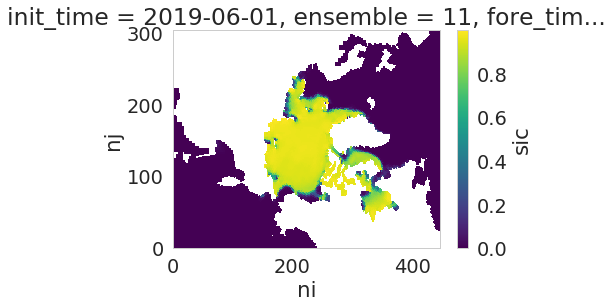

In [47]:
#plt.figure()
#ds_new.sic.sel(ensemble=11).isel(fore_time=0,init_time=0).plot()